In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

/Users/victor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Creating a Baseline Model

In [2]:
traffic_final_imp = pd.read_csv('traffic_final.csv', delimiter = ',') # do we want older or more recent data ?
traffic_final_imp = traffic_final_imp.rename(columns={"timestamp":"Date et heure de comptage"})
traffic_final_imp.head()


,Unnamed: 0,Libelle,arrondissement,Débit horaire,Taux d'occupation,Date et heure de comptage,temp,humidity,rain,wind_speed,...,ongoing_market,year_day,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
0,0,AV_Champs_Elysees,75008,764.0,11.28000,2023-02-01 22:00:00+00:00,6.733333,76.000000,0.0,3.133333,...,0,32,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.866025,-0.500000
1,1,AV_Champs_Elysees,75008,819.0,16.52056,2023-02-01 21:00:00+00:00,7.400000,73.000000,0.0,3.300000,...,0,32,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.707107,-0.707107
2,2,AV_Champs_Elysees,75008,1082.0,19.98722,2023-02-01 19:00:00+00:00,8.066667,67.000000,0.0,3.566667,...,1,32,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.258819,-0.965926
3,3,AV_Champs_Elysees,75008,1027.0,23.27334,2023-02-01 17:00:00+00:00,8.266667,65.111111,0.0,3.622222,...,1,32,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,-0.258819,-0.965926
4,4,Sts_Peres,75007,257.0,3.04445,2023-08-09 22:00:00+00:00,16.533333,83.333333,0.0,0.633333,...,0,221,-0.748511,-0.663123,-0.900969,-0.433884,-0.788305,-0.615285,0.866025,-0.500000


In [3]:
champs = traffic_final_imp[traffic_final_imp['Libelle'] == "AV_Champs_Elysees"].sort_values(by=["Date et heure de comptage"], ascending=True)
st_peres = traffic_final_imp[traffic_final_imp['Libelle'] == "Sts_Peres"].sort_values(by=["Date et heure de comptage"], ascending=True)
convention = traffic_final_imp[traffic_final_imp['Libelle'] == "Convention"].sort_values(by=["Date et heure de comptage"], ascending=True)

In [7]:
class BaselineAverage:
    def __init__(self):
        self.average_value = None

    def fit(self, time_series):
        # Calculate the average value of the time series
        self.average_value = time_series.mean()

    def predict(self, forecast_dates):
        # Check if the model has been fitted
        if self.average_value is None:
            raise ValueError("Model has not been fitted. Call fit() first.")

        # Create a DataFrame with forecast dates and corresponding average value predictions
        forecast_df = pd.DataFrame({
            'Date et heure de comptage': forecast_dates,
            'Débit horaire': [self.average_value] * len(forecast_dates)
        })
        forecast_df["Date et heure de comptage"] = pd.to_datetime(forecast_df["Date et heure de comptage"], utc=True)

        return forecast_df

In [8]:
baseline_model = BaselineAverage()
baseline_model.fit(champs['Débit horaire'])

In [9]:
date_range = pd.date_range(start='2023-12-01', end='2023-12-04', freq='H')

formatted_dates = date_range.strftime('%Y-%m-%dT%H:%M:%S%z')

predictions = baseline_model.predict(formatted_dates)

predictions

,Date et heure de comptage,Débit horaire
0,2023-12-01 00:00:00+00:00,884.490328
1,2023-12-01 01:00:00+00:00,884.490328
2,2023-12-01 02:00:00+00:00,884.490328
3,2023-12-01 03:00:00+00:00,884.490328
4,2023-12-01 04:00:00+00:00,884.490328
...,...,...
68,2023-12-03 20:00:00+00:00,884.490328
69,2023-12-03 21:00:00+00:00,884.490328
70,2023-12-03 22:00:00+00:00,884.490328
71,2023-12-03 23:00:00+00:00,884.490328


In [23]:
predictions_without = predictions.drop(predictions.index[-2:])

merged_df = pd.merge(traffic_reel, predictions_without, on='Date et heure de comptage')

# Calculate the Mean Squared Error
mse = mean_squared_error(merged_df['Débit horaire'], merged_df['Real Debit'])
rmse = math.sqrt(mse)
print(rmse)

452.7154091167117


In [10]:
traffic_reel_formatted = traffic_reel.rename(columns={"Real Debit":"Débit horaire"})
reel_values = pd.concat([champs[['Débit horaire', 'Date et heure de comptage']], traffic_reel_formatted], ignore_index=True)
reel_values["Date et heure de comptage"] = pd.to_datetime(reel_values["Date et heure de comptage"], utc=True)

reel_values


,Débit horaire,Date et heure de comptage
0,672.0,2022-11-01 03:00:00+00:00
1,513.0,2022-11-01 04:00:00+00:00
2,494.0,2022-11-01 05:00:00+00:00
3,513.0,2022-11-01 06:00:00+00:00
4,484.0,2022-11-01 07:00:00+00:00
...,...,...
9380,1464.0,2023-12-03 18:00:00+00:00
9381,1385.0,2023-12-03 19:00:00+00:00
9382,1200.0,2023-12-03 20:00:00+00:00
9383,1266.0,2023-12-03 21:00:00+00:00


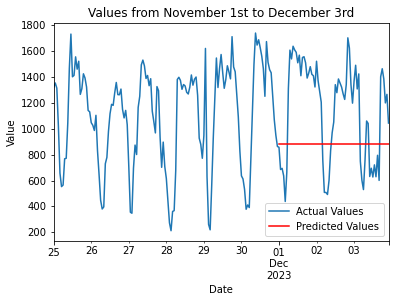

In [25]:
start_date = '2023-11-25'
end_date = '2023-12-04'
df_filtered = reel_values[(reel_values['Date et heure de comptage'] >= start_date) & (reel_values['Date et heure de comptage'] <= end_date)]


ax = df_filtered.plot(x='Date et heure de comptage', y='Débit horaire', kind='line', label='Actual Values', linestyle='-')

predictions_without.plot(x='Date et heure de comptage', y='Débit horaire', kind='line', label='Predicted Values', linestyle='-', color='red', ax=ax)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Values from November 1st to December 3rd')
plt.show()

# Testing an XG Boost Model

In [26]:
champs.head()

,Unnamed: 0,Date et heure de comptage,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,number_markets,ongoing_market,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
7299,7299,2022-11-01 03:00:00+00:00,4264,AV_Champs_Elysees,672.0,8.89223,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,7.071068e-01,0.707107
7298,7298,2022-11-01 04:00:00+00:00,4264,AV_Champs_Elysees,513.0,7.12889,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,5.000000e-01,0.866025
7297,7297,2022-11-01 05:00:00+00:00,4264,AV_Champs_Elysees,494.0,6.22500,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,2.588190e-01,0.965926
8665,8665,2022-11-01 06:00:00+00:00,4264,AV_Champs_Elysees,513.0,5.80723,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,1,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,6.123234e-17,1.000000
7296,7296,2022-11-01 07:00:00+00:00,4264,AV_Champs_Elysees,484.0,5.57111,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,1,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,-2.588190e-01,0.965926


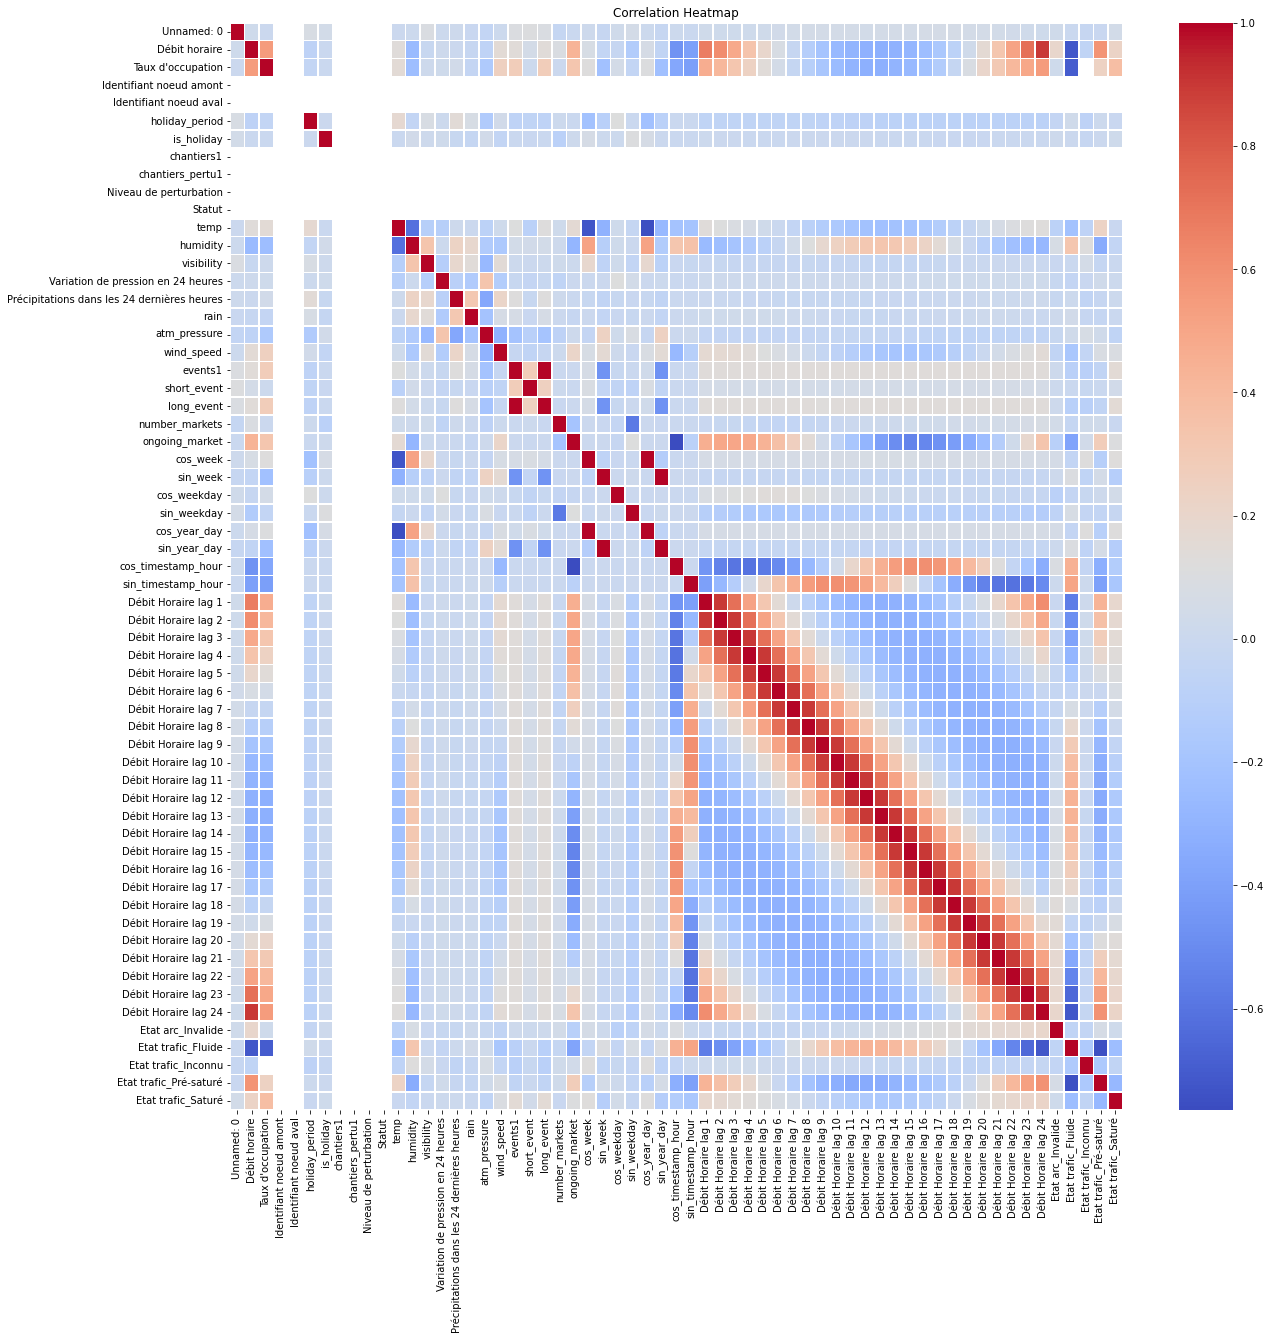

In [28]:
champs_numeric = champs_with_lags.drop(columns=['Libelle', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week'], errors='ignore')

champs_numeric = pd.get_dummies(champs_numeric, columns=['Etat arc', 'Etat trafic'], drop_first=True)
correlation_matrix = champs_numeric.corr()

# Create a heatmap
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [10]:
def xgboost_forecasting(data, n_test, predictor):
    
    train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    
    trainX, trainy = train.loc[:, ~train.columns.isin(['Débit horaire', "Taux d'occupation"])], train.loc[:, [predictor]]
    testX, testy = test.loc[:, ~train.columns.isin(['Débit horaire', "Taux d'occupation"])], test.loc[:, [predictor]]

    
    trainX = np.asarray(trainX)
    trainy = np.asarray(trainy)
    testX = np.asarray(testX)
    testy = np.asarray(testy)

    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)

    yhat = model.predict(testX)

    error = mean_squared_error(testy, yhat)

    rmse = np.sqrt(error)
    
    return testy, yhat, rmse

In [11]:
def xgboost_forecasting_final(data, reel_data, n_test, predictor):
    
    train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    
    trainX, trainy = train.loc[:, ~train.columns.isin(['Débit horaire', "Taux d'occupation"])], train.loc[:, [predictor]]
    testX, testy = test.loc[:, ~train.columns.isin(['Débit horaire', "Taux d'occupation"])], test.loc[:, [predictor]]

    
    trainX = np.asarray(trainX)
    trainy = np.asarray(trainy)
    testX = np.asarray(testX)
    testy = np.asarray(testy)

    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)

    yhat = model.predict(testX)

    error = mean_squared_error(testy, yhat)

    rmse = np.sqrt(error)
    
    ypred = model.predict(reel_data)
    
    return testy, ypred, rmse, model


In [14]:
champs_preproc = champs
champs_preproc["temp"] = champs_preproc["temp"].interpolate(method='linear')
champs_preproc["humidity"] = champs_preproc["humidity"].interpolate(method='linear')
champs_preproc["visibility"] = champs_preproc["visibility"].interpolate(method='linear')
champs_preproc["rain"] = champs_preproc["rain"].interpolate(method='linear')
champs_preproc["wind_speed"] = champs_preproc["wind_speed"].interpolate(method='linear')
champs_preproc["Débit horaire"] = champs_preproc["Débit horaire"].interpolate(method='linear')
champs_preproc["Taux d'occupation"] = champs_preproc["Taux d'occupation"].interpolate(method='linear')

champs_preproc = champs_preproc.drop(columns=['holiday', 'Date et heure de comptage', 'Unnamed: 0', 'Libelle', 'date', 'yearmonth', 'day_of_week'])

testy, yhat, rmse, model = xgboost_forecasting_final(champs_preproc, 72, 'Débit horaire')
testy2, yhat2, rmse2, model2 = xgboost_forecasting_final(champs_preproc, 72, "Taux d'occupation")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Define the data sets (replace these with your actual data)
datasets = [
    {'testy': testy, 'yhat': yhat},
    {'testy': testy2, 'yhat': yhat2}
]

titles = [
    'Debit Champs',
    'Taux Champs'
]

# Iterate through each subplot and plot the data
for i, data in enumerate(datasets):
    ax = axes[i]
    ax.plot(data['testy'], label='Expected', color='#a6c1d8')
    ax.plot(data['yhat'], label='Predicted', color='#b185b4')
    ax.legend()
    
    ax.set_title(titles[i])

TypeError: xgboost_forecasting_final() missing 1 required positional argument: 'predictor'

In [52]:
print(rmse)
print(rmse2)

222.3639282209076
9.518953483412291


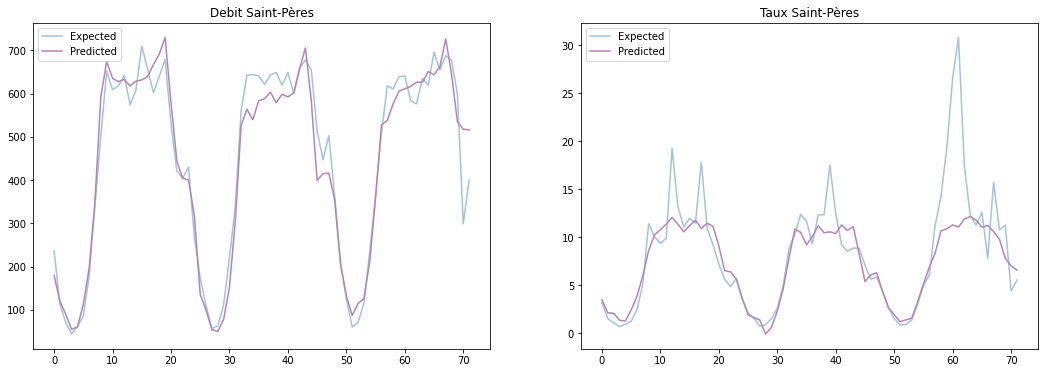

In [55]:
st_peres_preproc = st_peres
st_peres_preproc["temp"] = st_peres_preproc["temp"].interpolate(method='linear')
st_peres_preproc["humidity"] = st_peres_preproc["humidity"].interpolate(method='linear')
st_peres_preproc["visibility"] = st_peres_preproc["visibility"].interpolate(method='linear')
st_peres_preproc["rain"] = st_peres_preproc["rain"].interpolate(method='linear')
st_peres_preproc["wind_speed"] = st_peres_preproc["wind_speed"].interpolate(method='linear')
st_peres_preproc['Débit horaire'] = st_peres_preproc['Débit horaire'].interpolate(method='linear')
st_peres_preproc["Taux d'occupation"] = st_peres_preproc["Taux d'occupation"].interpolate(method='linear')

st_peres_preproc = st_peres_preproc.drop(columns=['holiday', 'Date et heure de comptage', 'Unnamed: 0', 'Libelle', 'date', 'yearmonth', 'day_of_week'])

testy, yhat, rmse = xgboost_forecasting(st_peres_preproc, 72, 'Débit horaire')
testy2, yhat2, rmse2 = xgboost_forecasting(st_peres_preproc, 72, "Taux d'occupation")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Define the data sets (replace these with your actual data)
datasets = [
    {'testy': testy, 'yhat': yhat},
    {'testy': testy2, 'yhat': yhat2}
]

titles = [
    'Debit Saint-Pères',
    'Taux Saint-Pères'
]

# Iterate through each subplot and plot the data
for i, data in enumerate(datasets):
    ax = axes[i]
    ax.plot(data['testy'], label='Expected', color='#a6c1d8')
    ax.plot(data['yhat'], label='Predicted', color='#b185b4')
    ax.legend()
    
    ax.set_title(titles[i])


In [56]:
print(rmse)
print(rmse2)


52.30053559775711
3.7932249040355908


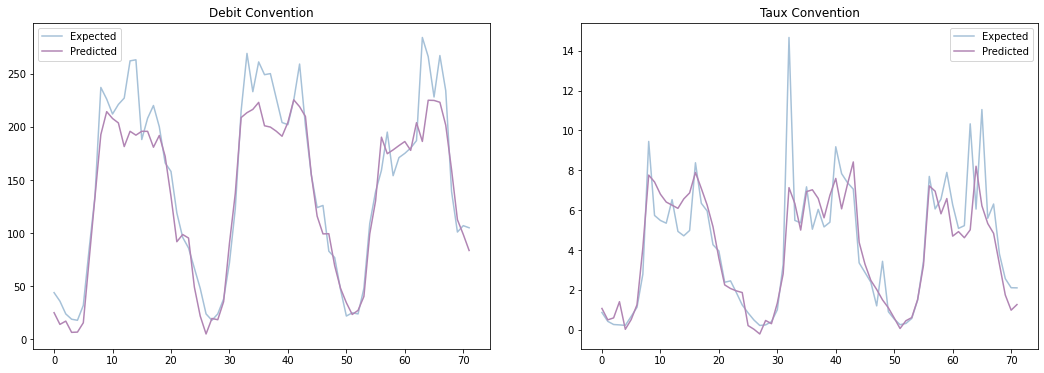

In [44]:
convention_preproc = convention

convention_preproc["temp"] = convention_preproc["temp"].interpolate(method='linear')
convention_preproc["humidity"] = convention_preproc["humidity"].interpolate(method='linear')
convention_preproc["visibility"] = convention_preproc["visibility"].interpolate(method='linear')
convention_preproc["rain"] = convention_preproc["rain"].interpolate(method='linear')
convention_preproc["wind_speed"] = convention_preproc["wind_speed"].interpolate(method='linear')
convention_preproc['Débit horaire'] = convention_preproc['Débit horaire'].interpolate(method='linear')
convention_preproc["Taux d'occupation"] = convention_preproc["Taux d'occupation"].interpolate(method='linear')

convention_preproc = convention_preproc.drop(columns=['holiday', 'Date et heure de comptage', 'Unnamed: 0', 'Libelle', 'date', 'yearmonth', 'day_of_week'])

testy, yhat, rmse = xgboost_forecasting(convention_preproc, 72, 'Débit horaire')
testy2, yhat2, rmse2 = xgboost_forecasting(convention_preproc, 72, "Taux d'occupation")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Define the data sets (replace these with your actual data)
datasets = [
    {'testy': testy, 'yhat': yhat},
    {'testy': testy2, 'yhat': yhat2}
]

titles = [
    'Debit Convention',
    'Taux Convention'
]

# Iterate through each subplot and plot the data
for i, data in enumerate(datasets):
    ax = axes[i]
    ax.plot(data['testy'], label='Expected', color='#a6c1d8')
    ax.plot(data['yhat'], label='Predicted', color='#b185b4')
    ax.legend()
    
    ax.set_title(titles[i])


In [58]:
print(rmse)
print(rmse2)

26.999378510962508
1.531749739284919


In [16]:
traffic_reel_imp = pd.read_csv('traffic_pred.csv', delimiter = ',') # do we want older or more recent data ?

traffic_reel_imp = traffic_reel_imp.rename(columns={"timestamp":"Date et heure de comptage"})
traffic_reel_imp.head()


,Unnamed: 0,Libelle,arrondissement,Date et heure de comptage,temp,humidity,rain,wind_speed,visibility,date,...,ongoing_market,year_day,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
0,0,AV_Champs_Elysees,75008,2023-12-08 00:00:00+00:00,5.3,97.78,1.9,11.1,96.1,2023-12-08,...,0,342,0.935016,-0.354605,0.62349,-0.781831,0.92264,-0.385663,1.000000,0.000000
1,1,AV_Champs_Elysees,75008,2023-12-08 01:00:00+00:00,6.0,95.62,1.0,10.0,100.0,2023-12-08,...,0,342,0.935016,-0.354605,0.62349,-0.781831,0.92264,-0.385663,0.965926,0.258819
2,2,AV_Champs_Elysees,75008,2023-12-08 02:00:00+00:00,6.0,100.00,0.0,7.4,100.0,2023-12-08,...,0,342,0.935016,-0.354605,0.62349,-0.781831,0.92264,-0.385663,0.866025,0.500000
3,3,AV_Champs_Elysees,75008,2023-12-08 03:00:00+00:00,6.6,95.64,0.1,9.4,100.0,2023-12-08,...,0,342,0.935016,-0.354605,0.62349,-0.781831,0.92264,-0.385663,0.707107,0.707107
4,4,AV_Champs_Elysees,75008,2023-12-08 04:00:00+00:00,6.9,97.81,0.0,10.0,96.1,2023-12-08,...,0,342,0.935016,-0.354605,0.62349,-0.781831,0.92264,-0.385663,0.500000,0.866025


# Predictions for 8 to 10 december

In [17]:
champs_reel = traffic_reel_imp[traffic_reel_imp['Libelle'] == "AV_Champs_Elysees"].sort_values(by=["Date et heure de comptage"], ascending=True)
st_peres_reel = traffic_reel_imp[traffic_reel_imp['Libelle'] == "Sts_Peres"].sort_values(by=["Date et heure de comptage"], ascending=True)
convention_reel = traffic_reel_imp[traffic_reel_imp['Libelle'] == "Convention"].sort_values(by=["Date et heure de comptage"], ascending=True)


In [19]:
champs_reel_preproc = champs_reel
champs_reel_preproc["temp"] = champs_reel_preproc["temp"].interpolate(method='linear')
champs_reel_preproc["humidity"] = champs_reel_preproc["humidity"].interpolate(method='linear')
champs_reel_preproc["visibility"] = champs_reel_preproc["visibility"].interpolate(method='linear')
champs_reel_preproc["rain"] = champs_reel_preproc["rain"].interpolate(method='linear')
champs_reel_preproc["wind_speed"] = champs_reel_preproc["wind_speed"].interpolate(method='linear')

champs_reel_preproc = champs_reel_preproc.drop(columns=['holiday', 'Date et heure de comptage', 'Unnamed: 0', 'Libelle', 'date', 'yearmonth', 'day_of_week'])

test_champs_y, ypred_champs_, rmse_champs_, model = xgboost_forecasting_final(champs_preproc, champs_reel_preproc, 72, 'Débit horaire')
test_champs_y2, ypred_champs_2, rmse_champs_2, model2 = xgboost_forecasting_final(champs_preproc, champs_reel_preproc, 72, "Taux d'occupation")



In [29]:
import shap

# Compute SHAP values
explainer_debit = shap.TreeExplainer(model)
shap_values_debit = explainer_debit.shap_values(champs_preproc.loc[:, ~champs_preproc.columns.isin(['Débit horaire', "Taux d'occupation"])])

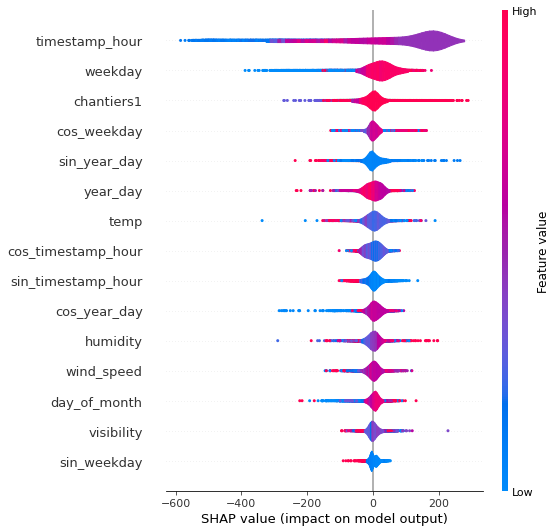

In [28]:
# Plot SHAP values for Débit horaire
shap.summary_plot(shap_values_debit, champs_preproc.loc[:, ~champs_preproc.columns.isin(['Débit horaire', "Taux d'occupation"])], max_display=15, plot_type="violin")
plt.show()

In [76]:
st_peres_reel_preproc = st_peres_reel
st_peres_reel_preproc["temp"] = st_peres_reel_preproc["temp"].interpolate(method='linear')
st_peres_reel_preproc["humidity"] = st_peres_reel_preproc["humidity"].interpolate(method='linear')
st_peres_reel_preproc["visibility"] = st_peres_reel_preproc["visibility"].interpolate(method='linear')
st_peres_reel_preproc["rain"] = st_peres_reel_preproc["rain"].interpolate(method='linear')
st_peres_reel_preproc["wind_speed"] = st_peres_reel_preproc["wind_speed"].interpolate(method='linear')

st_peres_reel_preproc = st_peres_reel_preproc.drop(columns=['holiday', 'Date et heure de comptage', 'Unnamed: 0', 'Libelle', 'date', 'yearmonth', 'day_of_week'])

test_st_peres_y, ypred_st_peres_, rmse_st_peres_ = xgboost_forecasting_final(st_peres_preproc, st_peres_reel_preproc, 72, 'Débit horaire')
test_st_peres_y2, ypred_st_peres_2, rmse_st_peres_2 = xgboost_forecasting_final(st_peres_preproc, st_peres_reel_preproc, 72, "Taux d'occupation")


In [46]:
convention_reel_preproc = convention_reel
convention_reel_preproc["temp"] = convention_reel_preproc["temp"].interpolate(method='linear')
convention_reel_preproc["humidity"] = convention_reel_preproc["humidity"].interpolate(method='linear')
convention_reel_preproc["visibility"] = convention_reel_preproc["visibility"].interpolate(method='linear')
convention_reel_preproc["rain"] = convention_reel_preproc["rain"].interpolate(method='linear')
convention_reel_preproc["wind_speed"] = convention_reel_preproc["wind_speed"].interpolate(method='linear')

convention_reel_preproc = convention_reel_preproc.drop(columns=['holiday', 'Date et heure de comptage', 'Unnamed: 0', 'Libelle', 'date', 'yearmonth', 'day_of_week'])

test_convention_y, ypred_convention_, rmse_convention_, model = xgboost_forecasting_final(convention_preproc, convention_reel_preproc, 72, 'Débit horaire')
test_convention_y2, ypred_convention_2, rmse_convention_2, model2 = xgboost_forecasting_final(convention_preproc, convention_reel_preproc, 72, "Taux d'occupation")


In [80]:
df = pd.DataFrame({'arc': 'Champs-Elysées', 'Date': champs_reel['Date et heure de comptage'], 'debit_horaire': ypred_champs_, 'taux_occupation': ypred_champs_2})
df2 = pd.DataFrame({'arc': 'Convention', 'Date': convention_reel['Date et heure de comptage'], 'debit_horaire': ypred_st_peres_, 'taux_occupation': ypred_st_peres_2})
df3 = pd.DataFrame({'arc': 'Saint-Pères', 'Date': st_peres_reel['Date et heure de comptage'], 'debit_horaire': ypred_convention_, 'taux_occupation': ypred_convention_2})

result_df = pd.concat([df, df2, df3], ignore_index=True)

In [81]:
result_df.to_csv("traffic_predictions.csv")

In [48]:
reel_data = pd.read_csv('comptages-routiers-permanents.csv', delimiter=';')
reel_data2 = pd.read_csv('comptages-routiers-permanents-3.csv', delimiter=';')
reel_data2['Libelle noeud amont'].unique()

reel_data_new = reel_data[reel_data["Libelle noeud amont"].isin(['Convention-Blomet'])]
reel_data_new = reel_data_new[reel_data_new["Libelle noeud aval"].isin(['Lecourbe-Convention']) ]
reel_data_new['Date et heure de comptage'] = pd.to_datetime(reel_data_new['Date et heure de comptage'], utc=True)
reel_data_new = reel_data_new.sort_values(by=['Date et heure de comptage'])
reel_data_new = reel_data_new[reel_data_new['Date et heure de comptage'] < '2023-12-13']
reel_data_new = reel_data_new.iloc[1:,:]

reel_data2_new = reel_data2[reel_data2["Libelle noeud amont"].isin(['Sts_Peres-Voltaire'])]
reel_data2_new = reel_data2_new[reel_data2_new["Libelle noeud aval"].isin(['Sts_Peres-Universite']) ]
reel_data2_new['Date et heure de comptage'] = pd.to_datetime(reel_data2_new['Date et heure de comptage'], utc=True)
reel_data2_new = reel_data2_new.sort_values(by=['Date et heure de comptage'])
reel_data2_new = reel_data2_new[reel_data2_new['Date et heure de comptage'] < '2023-12-11']
reel_data2_new = reel_data2_new.iloc[1:,:]

reel_data3_new = reel_data2[reel_data2["Libelle noeud amont"].isin(['Convention-Blomet'])]
reel_data3_new = reel_data3_new[reel_data3_new["Libelle noeud aval"].isin(['Lecourbe-Convention']) ]
reel_data3_new['Date et heure de comptage'] = pd.to_datetime(reel_data3_new['Date et heure de comptage'], utc=True)
reel_data3_new = reel_data3_new.sort_values(by=['Date et heure de comptage'])
reel_data3_new = reel_data3_new[reel_data3_new['Date et heure de comptage'] < '2023-12-11']
reel_data3_new = reel_data3_new.iloc[1:,:]

reel_data2_new.head()

,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape
65,191,Sts_Peres,2023-12-08 00:00:00+00:00,317.0,4.06167,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,1996-10-03,2023-01-01,"48.85728037029828, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826..."
64,191,Sts_Peres,2023-12-08 01:00:00+00:00,149.0,1.95611,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,1996-10-03,2023-01-01,"48.85728037029828, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826..."
63,191,Sts_Peres,2023-12-08 02:00:00+00:00,105.0,1.37611,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,1996-10-03,2023-01-01,"48.85728037029828, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826..."
20,191,Sts_Peres,2023-12-08 03:00:00+00:00,77.0,1.00167,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,1996-10-03,2023-01-01,"48.85728037029828, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826..."
19,191,Sts_Peres,2023-12-08 04:00:00+00:00,84.0,1.10278,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,1996-10-03,2023-01-01,"48.85728037029828, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826..."


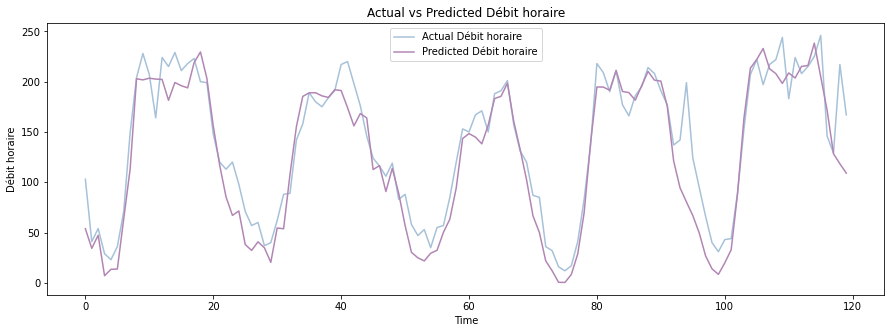

In [49]:
import matplotlib.pyplot as plt

# Extract the true and predicted values from the DataFrame
y_true = reel_data_new['Débit horaire']
y_true = y_true.reset_index(drop=True)

# Plot for Débit horaire
plt.figure(figsize=(15, 5))
plt.plot(y_true, label='Actual Débit horaire', color='#a6c1d8')
plt.plot(ypred_convention_, label='Predicted Débit horaire', color='#b185b4')
plt.title('Actual vs Predicted Débit horaire')
plt.xlabel('Time')
plt.ylabel('Débit horaire')
plt.legend()
plt.show()